# K-Nearest Neighbors

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

## Load datasets

In [2]:
# load data


def load_abalone(path):
    df = pd.read_csv(path)
    df = df.set_axis(
        [
            "sex",
            "length",
            "diameter",
            "height",
            "whole weight",
            "shucked weight",
            "viscera weight",
            "shell weight",
            "rings",
        ],
        axis=1,
    )
    return df


def load_breast_cancer(path):
    df = pd.read_csv(path)
    df = df.set_axis(
        [
            "sample code number",
            "clump thickness",
            "uniformity of cell size",
            "uniformity of cell shape",
            "marginal adhesion",
            "single epithelial cell size",
            "bare nuclei",
            "bland chromatin",
            "normal nucleoli",
            "mitoses",
            "class",
        ],
        axis=1,
    )
    df = df.drop(columns=["sample code number"])
    df = df.replace("?", np.nan)
    df["bare nuclei"] = df["bare nuclei"].astype(float)
    return df


def load_car(path):
    df = pd.read_csv(path)
    df = df.set_axis(
        ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"], axis=1
    )
    return df


def load_forest_fires(path):
    df = pd.read_csv(path)
    df = df.set_axis(
        [
            "X",
            "Y",
            "month",
            "day",
            "FFMC",
            "DMC",
            "DC",
            "ISI",
            "temp",
            "RH",
            "wind",
            "rain",
            "area",
        ],
        axis=1,
    )
    return df


def load_house_votes(path):
    df = pd.read_csv(path)
    df = df.set_axis(
        [
            "class",
            "handicapped infants",
            "water project cost sharing",
            "adoption of the budget resolution",
            "physician fee freeze",
            "el salvador aid",
            "religious groups in schools",
            "anti satellite test ban",
            "aid to nicaraguan contras",
            "mx missile",
            "immigration",
            "synfuels corporation cutback",
            "education spending",
            "superfund right to sue",
            "crime",
            "duty free exports",
            "export administration act south africa",
        ],
        axis=1,
    )
    return df


def load_machine(path):
    df = pd.read_csv(path)
    df = df.set_axis(
        [
            "vendor",
            "model",
            "MYCT",
            "MMIN",
            "MMAX",
            "CACH",
            "CHMIN",
            "CHMAX",
            "PRP",
            "ERP",
        ],
        axis=1,
    )
    df = df.drop(["vendor", "model"], axis=1)
    return df

## Data Processing Functions

In [3]:
# data cleaning


def impute_mean(data, columns, data_type=float):
    for column in columns:
        data[column] = data[column].fillna(data[column].mean()).astype(data_type)
    return


def encode_ordinal(data, column, relationship):
    print(f"encoding column: {column}")
    for index, rank in enumerate(relationship):
        data[column] = data[column].replace(rank, index)
        print(f"value: {rank} as: {index}")
    return


def one_hot_encode(data, columns):
    for col in columns:
        hot = pd.get_dummies(data[col], prefix=col, drop_first=True, dtype=int)
        data = pd.concat([data, hot], axis=1)
        data = data.drop(columns=[col])
    return data


def discretize_feature(data, columns, number_bins, type_bins):
    for col in columns:
        if type_bins == "frequency":
            binned = pd.qcut(data[col], q=number_bins, precision=0, duplicates="drop")
            data[col] = binned

        if type_bins == "width":
            binned = pd.cut(data[col], number_bins)
            data[col] = binned

    return


def standardize(training_data, test_data, columns):
    _data_train = deepcopy(training_data)
    _data_test = deepcopy(test_data)
    for _column in columns:
        mean = _data_train[_column].mean()
        std = _data_train[_column].std()
        print("test and train dataset z-score parameters used:\n")
        print(f"mean: {mean}\n")
        print(f"standard deviation: {std}\n")
        z_train = (_data_train[_column] - mean) / std
        z_test = (_data_test[_column] - mean) / std

        _data_train[_column] = z_train
        _data_test[_column] = z_test
    return _data_train, _data_test

## Cross-validation Functions

In [4]:
# data folding


def extract_validation_set(data, target):
    stratify_20 = data.groupby(target, group_keys=False).sample(frac=0.20)
    stratify_80 = data.drop(stratify_20.index).sample(frac=1)

    return stratify_80, stratify_20


def create_train_test(folds, index):
    test = []
    training = pd.DataFrame()
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = pd.concat([training, fold])
    return training, test


def stratified_k_fold(data, k, target):
    _data = deepcopy(data)

    split = []
    unique_keys = _data.value_counts(subset=target, normalize=True).keys()
    split_class = [_data.loc[_data[target] == keys] for keys in unique_keys]

    for class_value in split_class:
        d, m = divmod(len(class_value), k)
        split.append(
            [
                class_value[i * d + min(i, m) : (i + 1) * d + min(i + 1, m)]
                for i in range(k)
            ]
        )

    folds = [
        pd.concat([split[i][c] for i in range(len(unique_keys))]) for c in range(k)
    ]

    return folds


def k_fold(data, k):
    _data = deepcopy(data)

    d, m = divmod(len(_data), k)
    folds = list(
        _data[i * d + min(i, m) : (i + 1) * d + min(i + 1, m)] for i in range(k)
    )

    return folds


def evaluation(ground_truth, predicted_values, metric):
    if metric == "classification_score":
        count = 0
        for index, value in enumerate(ground_truth):
            if predicted_values[index] == value:
                count += 1
        count = count / len(ground_truth)
        return count
    if metric == "mse":
        error = sum((np.array(ground_truth) - np.array(predicted_values)) ** 2) / len(
            ground_truth
        )
        return error

In [5]:
def k_fold_cross_validation_sets(
    data, k, class_column, stratified=True, validation=True
):
    if validation is True:
        train, validation = extract_validation_set(data, class_column)
        if stratified is True:
            train = stratified_k_fold(train, k, class_column)
        else:
            train = k_fold(train, k)
        return train, validation

    else:
        if stratified is True:
            train = stratified_k_fold(data, k, class_column)
        else:
            train = k_fold(data, k)
    return train

In [6]:
def feature_class_probability(data, feature, feature_column, class_column):
    result = {}
    count_feature_x = data[feature_column][data[feature_column] == feature].count()

    unique_classes = data[class_column].unique()

    for u in unique_classes:
        number_with_class = data[feature_column][
            (data[feature_column] == feature) & (data[class_column] == u)
        ].count()
        if count_feature_x == 0 or number_with_class == 0:
            probability_by_feature = 0
            result[u] = probability_by_feature
        else:
            probability_by_feature = number_with_class / count_feature_x
            result[u] = probability_by_feature
    return result

In [7]:
def feature_probability_matrix(data, class_column):
    single_feature_frame = pd.DataFrame()
    final_frame = pd.DataFrame()
    feature_probability = {}
    for feature in data.keys():
        if feature != class_column:
            if not isinstance(data[feature].min(), np.integer) or not isinstance(
                data[feature].max(), np.integer
            ):
                print(f"{feature}: is not discrete")
                return final_frame

            for spread in range(data[feature].min(), data[feature].max() + 1):
                feature_probability[feature] = feature_class_probability(
                    data, spread, feature, class_column
                )
                reform = {
                    (outerKey, innerKey): values
                    for outerKey, innerDict in feature_probability.items()
                    for innerKey, values in innerDict.items()
                }
                single_feature_frame = pd.concat(
                    [single_feature_frame, pd.DataFrame(reform, index=[spread])]
                )
                feature_probability = {}
            final_frame = pd.concat([final_frame, single_feature_frame], axis=1)
            single_feature_frame = pd.DataFrame()
    final_frame.fillna(0, inplace=True)
    return final_frame

In [8]:
def value_difference_metric(
    data, feature_1, feature_2, feature_column, probability_matrix
):
    # Na,x number of instances attribute a has value x
    # Na,x,c number of instances attribute a has value x and class c
    # C number of output classes
    # q = constant 1 or 2
    # Pa,x,c probability output class is c given a is x = Na,x,c/Na,x
    # vdm_a(x,y)=sum(Pa,x,c - Pa,y,c)^q = distance between features
    # distance between two examples = sum(vdm_a over all features)^1/q
    probability_x = probability_matrix[feature_column].loc[feature_1]
    probability_y = probability_matrix[feature_column].loc[feature_2]
    vdm = np.sum((probability_x.values - probability_y.values) ** 2)
    return vdm

In [9]:
def categorical_distance(data, point1, point2, class_column, probability_matrix):
    distance = []
    for feature in point2.keys():
        if feature != class_column:
            distance.append(
                value_difference_metric(
                    data, point1[feature], point2[feature], feature, probability_matrix
                )
            )
    distance = np.sqrt(sum(distance))
    return distance

In [10]:
def knn_classification(data, k, query, class_column, probability_matrix, edit=False):
    distances = []
    classifier = []

    for index, example in data.iterrows():
        d = (
            categorical_distance(
                data, query, example, class_column, probability_matrix
            ),
            index,
        )
        distances.append(d)
        if edit is True:
            if d[0] == 0:
                result = data.loc[d[1]][class_column]
                return result, d

    distances.sort()

    if isinstance(k, list):
        result = []
        for index in k:
            nearest = distances[:index]
            for value in nearest:
                classifier.append(data.loc[value[1]][class_column])
            result.append(max(set(classifier), key=classifier.count))
        return result

    else:
        nearest = distances[:k]
        print(f"query {query}")
        print(f"nearest {nearest}")
        for value in nearest:
            classifier.append(data.loc[value[1]][class_column])
        result = max(set(classifier), key=classifier.count)
        print(f"result {result}")

    return result, nearest

In [11]:
def euclidian_distance(example, query):
    distance = 0.0
    for i, dimension in enumerate(example):
        distance += (dimension - query[i]) ** 2
    distance = np.sqrt(distance)
    return distance

In [12]:
def gaussian_kernel(distance, sigma):
    print(distance)
    print(sigma)
    kernel = np.exp((-1 / sigma) * distance[0])
    return kernel

In [13]:
def kernel_smoother(data, distances, sigma, epsilon, class_column):
    kernel = []
    weights = []
    r = []
    for index, t in enumerate(distances):
        kernel.append(gaussian_kernel(distances[index], sigma))
        weights.append(np.divide(distances[index][0], distances[-1][0]))
        r.append(data.loc[distances[index][1]][class_column] + epsilon)
        print(f"kernel {kernel}")
        print(f"weights {weights}")
        print(f"r {r}")
    g = sum(np.array(kernel) * np.array(weights) * np.array(r)) / sum(
        np.array(kernel) * np.array(weights)
    )
    print(f"g {g}")
    return g

In [14]:
def knn_regression(data, k, query, class_column, sigma, epsilon):
    distances = []
    classifier = []
    for index, example in data.iterrows():
        d = (euclidian_distance(example, query), index)
        if d[0] != 0:
            distances.append(d)
    distances.sort()
    nearest = distances[:k]
    print(f"query {query}")
    print(f"nearest {nearest}")
    classifier = kernel_smoother(data, nearest, sigma, epsilon, class_column)
    print(f"classification {classifier}")
    return classifier, nearest

## Breast Cancer Data Set KNN Classification
* KNN
* Edited KNN
* Condensed KNN
* Classification by plurality vote
* 5-fold cross-validation
* Classification error loss function

In [15]:
def cancer_data_conditioning(path):
    data = load_breast_cancer(path)
    impute_mean(data, ["bare nuclei"], int)
    data = data.drop_duplicates()
    sets = k_fold_cross_validation_sets(data, 5, "class", stratified=True)
    return sets

In [16]:
cancer_train, cancer_validation = cancer_data_conditioning(
    "datasets/breast-cancer-wisconsin.data"
)

In [17]:
def cancer_parameter_tuning(data, validate, k_tune):
    average = []
    classification_error = []
    error = []
    for index, _ in enumerate(data):
        knn_estimate = []
        print(f"fold {index+1}")
        train, _ = create_train_test(data, index)
        probability_matrix = feature_probability_matrix(train, "class")

        for _, test_point in validate.iterrows():
            e = knn_classification(
                train, k_tune, test_point, "class", probability_matrix
            )
            knn_estimate.append(e)

        
        actual = [validate.iloc[i]["class"] for i in range(len(validate))]
        for i, k in enumerate(k_tune):
            predicted = []
            for v in knn_estimate:
                predicted.append(v[i])
            classification_error.append(
                evaluation(actual, predicted, "classification_score")
            )
            print(
                f"Fold {index+1} k={k} classification accuracy: {classification_error[i]}"
            )

        error.append(classification_error)
        classification_error = []
    for i, k in enumerate(k_tune):
        average.append(sum([error[c][i] for c in range(len(error))]) / len(error))
        print(f"\nAverage classification accuracy for k = {k}: {average[i]}")
    return average

fold 1


Fold 1 k=1 classification accuracy: 0.956989247311828
Fold 1 k=2 classification accuracy: 0.956989247311828
Fold 1 k=3 classification accuracy: 0.9354838709677419
Fold 1 k=4 classification accuracy: 0.946236559139785
Fold 1 k=5 classification accuracy: 0.967741935483871
Fold 1 k=6 classification accuracy: 0.967741935483871
Fold 1 k=7 classification accuracy: 0.967741935483871
Fold 1 k=8 classification accuracy: 0.967741935483871
Fold 1 k=9 classification accuracy: 0.967741935483871
fold 2
Fold 2 k=1 classification accuracy: 0.956989247311828
Fold 2 k=2 classification accuracy: 0.956989247311828
Fold 2 k=3 classification accuracy: 0.9354838709677419
Fold 2 k=4 classification accuracy: 0.956989247311828
Fold 2 k=5 classification accuracy: 0.967741935483871
Fold 2 k=6 classification accuracy: 0.967741935483871
Fold 2 k=7 classification accuracy: 0.967741935483871
Fold 2 k=8 classification accuracy: 0.978494623655914
Fold 2 k=9 classification accuracy: 0.978494623655914
fold 3
Fold 3 k=1 c

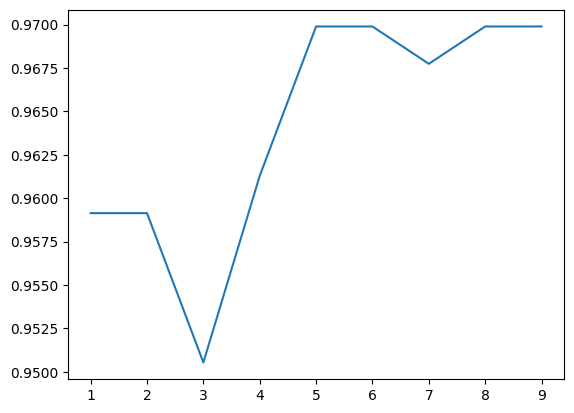

In [18]:
%%time
k_tune = [1, 2, 3, 4, 5, 6, 7, 8, 9]
cancer_avg = cancer_parameter_tuning(cancer_train, cancer_validation, k_tune)
plt.plot(k_tune, cancer_avg)

In [19]:
def cancer_knn(data, k):
    print(f"\nparameter k: {k}")
    classification_error = []
    for i_fold, _ in enumerate(data):
        knn_estimate = []
        train, test = create_train_test(data, i_fold)
        probability_matrix = feature_probability_matrix(train, "class")
        for _, test_point in test.iterrows():
            e, _ = knn_classification(train, k, test_point, "class", probability_matrix)
            knn_estimate.append(e)
        actual = [test.iloc[i]["class"] for i in range(len(test))]
        classification_error.append(
            evaluation(actual, knn_estimate, "classification_score")
        )
        print(
            f"Fold {i_fold+1} classification accuracy: {classification_error[i_fold]}"
        )
    average = sum(classification_error) / len(classification_error)
    print(f"Average classification accuracy: {average}")
    return average

In [20]:
%%time
cancer_knn(cancer_train, 5)


parameter k: 5


query clump thickness                5
uniformity of cell size        3
uniformity of cell shape       3
marginal adhesion              4
single epithelial cell size    2
bare nuclei                    4
bland chromatin                3
normal nucleoli                4
mitoses                        1
class                          4
Name: 50, dtype: int64
nearest [(0.610645475149953, 100), (0.8398611271780848, 11), (1.0099963401438308, 414), (1.073401514621716, 292), (1.09995601423021, 239)]
result 4
query clump thickness                10
uniformity of cell size         4
uniformity of cell shape        5
marginal adhesion               5
single epithelial cell size     5
bare nuclei                    10
bland chromatin                 4
normal nucleoli                 1
mitoses                         1
class                           4
Name: 232, dtype: int64
nearest [(0.4071614254947326, 183), (0.4321697277925451, 415), (0.5488214328088755, 53), (0.5873237570146507, 17), (0.64867

0.9567197334320621

In [35]:
def cancer_knn_editing(_data):
    data = deepcopy(_data)
    data = data.sample(frac=1)
    probability_matrix = feature_probability_matrix(data, "class")
    for i_test, test_point in data.iterrows():
        e, _ = knn_classification(
            data, 1, test_point, "class", probability_matrix, edit=True
        )
        actual = data.loc[i_test]["class"]
        if e == actual:
            print(f"point removed {data.loc[i_test]}")
            print(len(data))
            data = data.drop(i_test)
            print(len(data))
        return data
    return data

In [22]:
def edit_set(data):
    training = pd.DataFrame()
    for i, fold in enumerate(data):
        training = pd.concat([training, fold])
    return training

In [23]:
def cancer_edit_verify(data, validation, k):
    classification_error = []
    knn_estimate = []
    probability_matrix = feature_probability_matrix(data, "class")
    for i_test, test_point in validation.iterrows():
        e, n = knn_classification(
            data, k, test_point, "class", probability_matrix, edit=True
        )
        knn_estimate.append(e)
    actual = [validation.iloc[i]["class"] for i in range(len(validation))]
    classification_error = evaluation(actual, knn_estimate, "classification_score")
    print(f"classification accuracy: {classification_error}")
    return classification_error

In [24]:
def edit_loop(data, validation):
    reduced_set = cancer_knn_editing(data)
    for i in range(100):
        reduced_set = cancer_knn_editing(reduced_set)
    accuracy = cancer_edit_verify(reduced_set, validation, 1)
    while accuracy > 0.92:
        if len(reduced_set) > 20:
            for i in range(20):
                reduced_set = cancer_knn_editing(reduced_set)
        else:
            reduced_set = cancer_knn_editing(reduced_set)
        accuracy = cancer_edit_verify(reduced_set, validation, 1)
    return reduced_set

In [36]:
cancer_edit_set = edit_set(cancer_train)
cancer_edit_validation = edit_set([cancer_validation])
cancer_edited_set = edit_loop(cancer_edit_set, cancer_edit_validation)

345
point removed clump thickness                5
uniformity of cell size        2
uniformity of cell shape       2
marginal adhesion              2
single epithelial cell size    3
bare nuclei                    1
bland chromatin                1
normal nucleoli                3
mitoses                        1
class                          2
Name: 345, dtype: int64
369
368
570
point removed clump thickness                 7
uniformity of cell size         6
uniformity of cell shape       10
marginal adhesion               5
single epithelial cell size     3
bare nuclei                    10
bland chromatin                 9
normal nucleoli                10
mitoses                         2
class                           4
Name: 570, dtype: int64
368
367
311
point removed clump thickness                 8
uniformity of cell size         6
uniformity of cell shape        4
marginal adhesion              10
single epithelial cell size    10
bare nuclei                     1
bland ch

In [37]:
cancer_edited_set

,clump thickness,uniformity of cell size,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitoses,class
159,10,7,7,4,5,10,5,7,2,4
349,5,1,1,3,2,1,1,1,1,2
308,3,1,1,1,2,5,5,1,1,2
101,4,1,2,1,2,1,3,1,1,2
598,5,2,4,1,1,1,1,1,1,2
6,2,1,2,1,2,1,3,1,1,2
377,3,1,1,4,3,1,2,2,1,2
481,9,10,10,10,10,5,10,10,10,4


In [38]:
%%time
sets = k_fold_cross_validation_sets(
    cancer_edited_set, 5, "class", stratified=True, validation=False
)
cancer_knn(sets, 5)


parameter k: 5
query clump thickness                5
uniformity of cell size        1
uniformity of cell shape       1
marginal adhesion              3
single epithelial cell size    2
bare nuclei                    1
bland chromatin                1
normal nucleoli                1
mitoses                        1
class                          2
Name: 349, dtype: int64
nearest [(1.0, 6), (1.0, 101), (1.0, 377), (1.0, 598), (4.123105625617661, 481)]
result 2
query clump thickness                3
uniformity of cell size        1
uniformity of cell shape       1
marginal adhesion              1
single epithelial cell size    2
bare nuclei                    5
bland chromatin                5
normal nucleoli                1
mitoses                        1
class                          2
Name: 308, dtype: int64
nearest [(1.7320508075688772, 6), (1.7320508075688772, 101), (1.7320508075688772, 377), (1.7320508075688772, 598), (3.872983346207417, 481)]
result 2
query clump thickness   

0.8333333333333334

In [39]:
def condensed_knn(data):
    k = 1
    condensed_set = pd.DataFrame()
    condensed_set = pd.concat([condensed_set, data.iloc[0:1]], ignore_index=True)
    condensed_set = pd.concat([condensed_set, data.iloc[359:360]], ignore_index=True)
    set_length = 0
    while len(condensed_set) != set_length:
        set_length = len(condensed_set)
        for i_train, train_point in data.iterrows():
            probability_matrix = feature_probability_matrix(condensed_set, "class")
            e, n = knn_classification(
                condensed_set, k, train_point, "class", probability_matrix
            )
            actual = data.loc[i_train]["class"]
            if actual != e:
                condensed_set = pd.concat(
                    [condensed_set, data.loc[i_train].to_frame().T], ignore_index=True
                )
                print(condensed_set)
    return condensed_set

In [40]:
cancer_condensed_set = condensed_knn(cancer_edit_set)

query clump thickness                5
uniformity of cell size        3
uniformity of cell shape       3
marginal adhesion              4
single epithelial cell size    2
bare nuclei                    4
bland chromatin                3
normal nucleoli                4
mitoses                        1
class                          4
Name: 50, dtype: int64
nearest [(0.0, 0)]
result 4


KeyError: 10

In [ ]:
cancer_condensed_set

In [ ]:
%%time
sets = k_fold_cross_validation_sets(
    cancer_condensed_set, 5, "class", stratified=True, validation=False
)
cancer_knn(sets, 5)

## Abalone Data Set KNN Regression
* KNN
* Edited KNN
* Condensed KNN
* Regression by Gaussian kernel
* 5-fold cross-validation
* Mean squared error loss function

In [ ]:
def abalone_data_conditioning(path):
    data = load_abalone(path)
    data = data.drop("sex", axis=1)
    data = data.drop_duplicates()
    sets = k_fold_cross_validation_sets(data, 5, "rings", stratified=False)
    return sets

In [ ]:
abalone_train, abalone_validation = abalone_data_conditioning("datasets/abalone.data")

In [ ]:
train_counts = [len(abalone_train[i]) for i in range(5)]
print(train_counts)
print(sum(train_counts))
validation_counts = [len(abalone_validation[i]) for i in range(5)]
print(validation_counts)
print(sum(validation_counts))
print(sum(train_counts) + sum(validation_counts))

In [ ]:
def abalone_parameter_tuning(data):
    k_tune = [13]
    average = []
    sig_tune = [0.1, 1, 5, 10, 15, 20, 50]
    eps_tune = [0.0001]
    for i_eps, eps in enumerate(eps_tune):
        for i_sig, s in enumerate(sig_tune):
            for i, k in enumerate(k_tune):
                classification_error = []
                error = []
                predicted = []
                for i_fold, fold in enumerate(data):
                    knn_estimate = []
                    print(f"fold for test i:{i_fold+1}")
                    train, test = create_train_test(data, i_fold)
                    for i_test, test_point in test.iterrows():
                        e, n = knn_regression(train, k, test_point, "rings", s, eps)
                        knn_estimate.append(e)
                    actual = [test.iloc[i]["rings"] for i in range(len(test))]
                    predicted = knn_estimate
                    error = evaluation(actual, predicted, "mse")
                    classification_error.append(error)
                    print(f"Fold {i_fold+1} epsilon={eps} mean squared error: {error}")
                average.append(sum(classification_error) / len(classification_error))
                print(f"\nAverage mean squared error for sigma = {s}: {average[i_sig]}")
    return average

In [ ]:
%%time
abalone_parameter_tuning(abalone_validation)

In [ ]:
# varying k
plt.plot(
    [1, 5, 9, 13, 17, 21],
    [
        3.9455714637190638,
        3.7860490531709323,
        3.768347136106648,
        3.760938579567278,
        3.761725532446775,
        3.7635997581853795,
    ],
)

In [ ]:
# varying sigma
plt.plot(
    [0.1, 1, 5, 10, 15, 20, 50],
    [
        3.7605902190456932,
        3.760851509248474,
        3.760938579567278,
        3.760950493327246,
        3.7609545159290425,
        3.760956536869064,
        3.76096019076427,
    ],
)

In [ ]:
# varying epsilon
plt.plot(
    [0.0001, 0.001, 0.01, 0.1, 1, 5, 7],
    [
        3.8173897429918435,
        3.8170005134407097,
        3.813197317929385,
        3.7840753628161314,
        4.383855811683546,
        26.64954669553873,
        49.782392137466324,
    ],
)

In [ ]:
def abalone_knn(data, k, sigma, epsilon):
    classification_error = []
    error = []
    predicted = []
    average = []
    for i_fold, fold in enumerate(data):
        knn_estimate = []
        print(f"fold for test i:{i_fold+1}")
        train, test = create_train_test(data, i_fold)
        for i_test, test_point in test.iterrows():
            e, n = knn_regression(train, k, test_point, "rings", sigma, epsilon)
            knn_estimate.append(e)
        actual = [test.iloc[i]["rings"] for i in range(len(test))]
        predicted = knn_estimate
        error = evaluation(actual, predicted, "mse")
        classification_error.append(error)
        print(f"Fold {i_fold+1} mean squared error: {error}")
    average.append(sum(classification_error) / len(classification_error))
    print(f"\nAverage mean squared error {average}")
    return average

In [ ]:
abalone_knn(abalone_train, 13, 5, 0.1)

In [ ]:
def abalone_knn_editing(_data):
    data = deepcopy(_data)
    knn_estimate = []
    neighbor = []
    data = data.sample(frac=1)
    for i_test, test_point in data.iterrows():
        e, n = knn_regression(data, 1, test_point, "rings", 5, 0.1)
        actual = data.loc[i_test]["rings"]
        if ((actual - 5) <= e) or (e <= (actual + 5)):
            data = data.drop(i_test)
        return data
    return data

In [ ]:
def abalone_edit_verify(data, validation, k):
    classification_error = []
    knn_estimate = []
    for i_test, test_point in validation.iterrows():
        e, n = knn_regression(validation, 1, test_point, "rings", 5, 1)
        knn_estimate.append(e)
    actual = [validation.iloc[i]["rings"] for i in range(len(validation))]
    classification_error = evaluation(actual, knn_estimate, "mse")
    print(f"mse: {classification_error}")
    return classification_error

In [ ]:
def abalone_edit_loop(data, validation):
    reduced_set = abalone_knn_editing(data)
    for i in range(1000):
        reduced_set = abalone_knn_editing(reduced_set)
        print(f"reduced set length {len(reduced_set)}")
    mse = abalone_edit_verify(reduced_set, validation, 1)
    while mse < 5:
        if len(reduced_set) > 500:
            for i in range(500):
                reduced_set = abalone_knn_editing(reduced_set)
        else:
            reduced_set = abalone_knn_editing(reduced_set)
        mse = abalone_edit_verify(reduced_set, validation, 1)
        print(f"reduced set length {len(reduced_set)}")
    return reduced_set

In [ ]:
%%time
abalone_edit_set = edit_set(abalone_train)
abalone_edit_validation = edit_set(abalone_validation)
abalone_edited_set = abalone_edit_loop(abalone_edit_set, abalone_edit_validation)

In [ ]:
abalone_edited_set

In [ ]:
%%time
sets = k_fold_cross_validation_sets(abalone_edited_set, 5, "rings")
abalone_knn(sets, 13, 5, 1)

In [ ]:
def abalone_condensed_knn(data):
    k = 1
    condensed_set = pd.DataFrame()
    condensed_set = pd.concat([condensed_set, data.iloc[0:1]], ignore_index=True)
    condensed_set = pd.concat([condensed_set, data.iloc[359:360]], ignore_index=True)
    set_length = 0
    while len(condensed_set) != set_length:
        set_length = len(condensed_set)
        for i_train, train_point in data.iterrows():
            e, n = knn_regression(condensed_set, 1, train_point, "rings", 5, 1)
            actual = data.loc[i_train]["rings"]
            if ((actual - 5) >= e) or (e >= (actual + 5)):
                condensed_set = pd.concat(
                    [condensed_set, data.loc[i_train].to_frame().T], ignore_index=True
                )
            print(f"length condensed set {len(condensed_set)}")
    return condensed_set

In [ ]:
abalone_condensed_set = abalone_condensed_knn(abalone_edit_set)

In [ ]:
abalone_condensed_set

In [ ]:
%%time
sets = k_fold_cross_validation_sets(
    cancer_condensed_set, 5, "class", stratified=True, validation=False
)
cancer_knn(sets, 5)

## Car Evaluation Data Set KNN Classification
* KNN
* Edited KNN
* Condensed KNN
* Classification by plurality vote
* 5-fold cross-validation
* Classification error loss function

In [ ]:
data_car = load_car("..\\..\\649 Intro to ML\\datasets\\car.data")
print(f"#rows={len(data_car)} #columns={len(data_car.columns)}")
print(data_car.dtypes)
data_car.head()

## Congressional Vote Data Set KNN Classification
* KNN
* Edited KNN
* Condensed KNN
* Classification by plurality vote
* 5-fold cross-validation
* Classification error loss function

In [ ]:
data_house = load_house_votes("..\\..\\649 Intro to ML\\datasets\\house-votes-84.data")
print(f"#rows={len(data_house)} #columns={len(data_house.columns)}")
print(data_house.dtypes)
data_house.head()

## Forest Fires Data Set KNN Regression
* KNN
* Edited KNN
* Condensed KNN
* Regression by Gaussian kernel
* 5-fold cross-validation
* Mean squared error loss function

In [ ]:
data_forest = load_forest_fires("..\\..\\649 Intro to ML\\datasets\\forestfires.data")
print(f"#rows={len(data_forest)} #columns={len(data_forest.columns)}")
print(data_forest.dtypes)
data_forest.head()

## Computer Hardware Data Set KNN Regression
* KNN
* Edited KNN
* Condensed KNN
* Regression by Gaussian kernel
* 5-fold cross-validation
* Mean squared error loss function

In [ ]:
data_machine = load_machine("..\\..\\649 Intro to ML\\datasets\\machine.data")
print(f"#rows={len(data_machine)} #columns={len(data_machine.columns)}")
print(data_machine.dtypes)
data_machine.head()